This notebook is intended to be used for photobleach calculations based on a kymograph collection of static fluorophores.

To setup a collection, begin by performing continuous confocal scans while lowering the Z-position with the silver knob.
When the Z focus is at the bottom edge of the slide, proteins stuck to the surface should fluoresce brightly.
To analyze photobleaching, start collecting a kymograph as in data collection settings 
until photon counts decrease to less than half of the original value.
This script should automatically fetch and bin the photon counts in the blue channel by second and plot them as a function of time.
Finally, an exponential decay fit determines the lifetime of the fluorophore (see figure 2)
Note that color still must be changed in cells 5 and 7 for colors other than blue


BSD 2-Clause License

Copyright (c) 2023, Matthew Schaich
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


In [22]:
import matplotlib.pyplot as plt
import lumicks.pylake as lk
import itertools
import ipywidgets
import numpy as np
import glob
import math
# We use skimage to downsample the data
from skimage.measure import block_reduce
from statistics import mean
from statistics import median
# Use notebook if you're in Jupyter Notebook
%matplotlib notebook

In [23]:
filename = glob.glob('*.h5') #fetches filename assuming only one .h5 in notebook
if len(filename) == 1:
    print (filename[0])
else: 
    print ("too many or too few .h5 files")

20220824-181058 Kymograph 4 pb1.h5


In [24]:
plt.close('all')
file = lk.File(str(filename[0]))
_, kymo = file.kymos.popitem()

In [25]:
forcex = file["Force HF"]["Force 1x"]

# time traces (seconds)
time = forcex.timestamps/1e9
time = time - time[0]
sample_rate = forcex.sample_rate

downsampled_rate = 600 # Hz
print (max(time), 'seconds is the length of the kymo') #displays the length of the kymo in seconds


kymo_time = np.floor(max(time))
# downsample the force, nanostage position and time
forcex_downsamp = forcex.downsampled_by(int(sample_rate/downsampled_rate))
time_downsamp = forcex_downsamp.timestamps/1e9
time_downsamp = time_downsamp - time_downsamp[0]

median_force = (median(forcex_downsamp.data))
#print (median(forcex_downsamp.data))
#print (mean(forcex_downsamp.data))

photons = file['Photon count']['Blue']
#print (len (photons)) for this dataset the number of timestamps in photon collection was 8017501
photonwindow = int(len(photons)/kymo_time) #divide the length of the dataset in seconds by the photon window to get photons/second

#1 second photons
photon_sum = 0
array_of_photon_sums = []
for k in range (1, int(kymo_time)):
    for i in range (k*photonwindow, (k+1)*photonwindow):  
        photon_sum = photon_sum + photons.data[i]
        if i == (k+1)*photonwindow-1:
            array_of_photon_sums.append(photon_sum)
            photon_sum = 0
            


65.53600001335144 seconds is the length of the kymo


In [26]:
_, kymo = file.kymos.popitem()
data = kymo.blue_image
downsample_factor = 1
data = block_reduce(data, (1, downsample_factor))

In [27]:
dt = downsample_factor * kymo.line_time_seconds

<IPython.core.display.Javascript object>


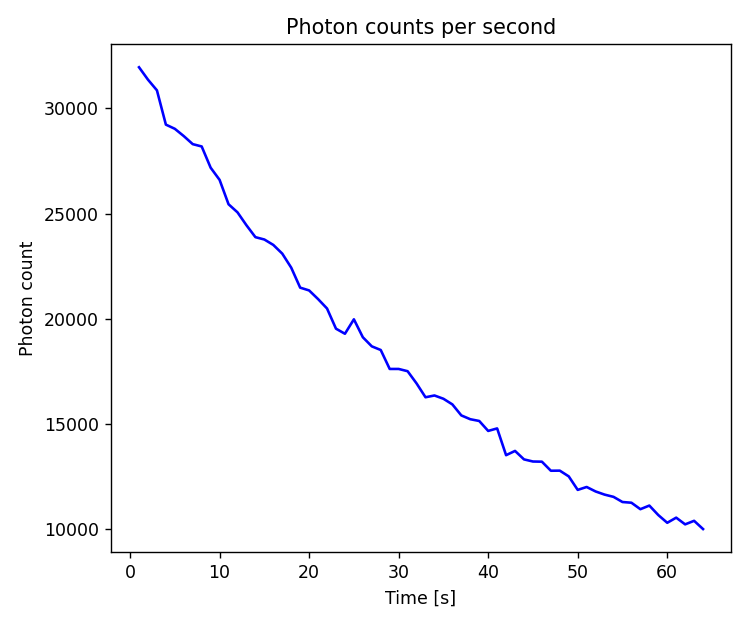

<IPython.core.display.Javascript object>


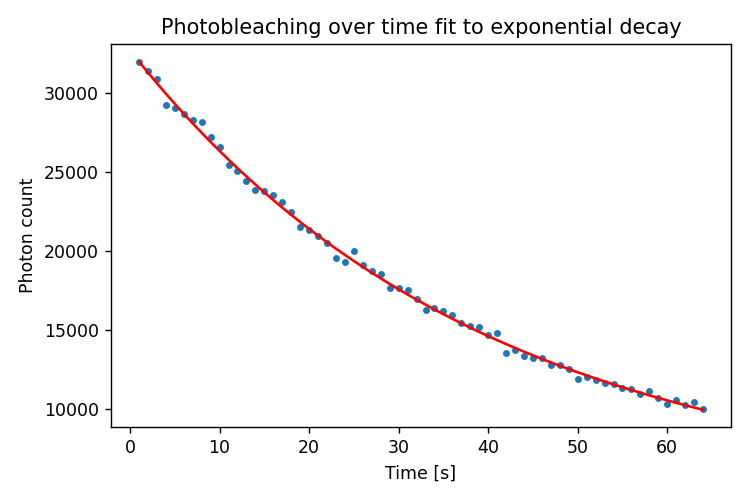

The R squared of the fit is 0.9981498444636432
Mean bleach time is 39.1510982577748 seconds


In [28]:
x = np.arange(1, int(kymo_time)) 
y = array_of_photon_sums
plt.figure(figsize=(6, 5))
plt.plot(x, y, color ="blue") 
plt.ylabel('Photon count')
plt.xlabel('Time [s]')
plt.title('Photon counts per second')
plt.tight_layout()
#plt.show()

from scipy.optimize import curve_fit
def func(x, a, b, c,d):

    return a * np.exp(-b * (x-d)) + c 
#NOTE: These bounds may need to be changed if the photon count is really high! Check if fit is near the bounds
popt, pcov = curve_fit(func, x, y, bounds=(0, [100000, 5, 50000, 5]), absolute_sigma=True)

plt.figure(figsize=(6,4))
plt.plot(x,y,'.')
plt.title('Photobleaching over time fit to exponential decay')
plt.ylabel('Photon count')
plt.xlabel('Time [s]')
plt.plot(x, func(x, *popt), 'r-',

         #label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt)
        )
lifetime = 1 / popt[1]

plt.tight_layout()
#plt.legend()
plt.show()
residuals = y- func(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print ('The R squared of the fit is', (r_squared))
print ('Photobleach lifetime is', (lifetime), 'seconds')
#note that the photobleach lifetime is 1/k , where k is the photobleach rate